# PNP

In [5]:
import numpy as np
import pandas as pd

## Passo 1: Leitura dos dados
Leitura dos bancos de dados em DataFrame Pandas. 

In [6]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_pre_processados_lazaro.csv'

In [7]:
df = pd.read_csv(caminho_dados_lazaro)

In [8]:
df.head()

,Piquete,Altura real,Altura esperada,Animal,SensorID,Sensor Name,Date,X,Y,Z,Comportamento,Season_fall,Season_spring,Season_summer,magn,sma,ent,pit,rol,icl
0,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:47,-0.132,-0.583,0.712,Ocio,0.0,1.0,0.0,0.929654,1.427,-0.005973,8.162915,129.311311,40.014999
1,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:48,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
2,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:50,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
3,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:51,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
4,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:52,-0.061,-0.870,0.478,Ocio,0.0,1.0,0.0,0.994538,1.409,-0.361029,3.516446,151.214493,61.273746


In [9]:
# Remove as linhas com o sensor 434138
df = df[df.SensorID != 434138]

## Passo 2: Treinamento e Validação

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
# Para a busca do melhores hiperparêmetros
from sklearn.model_selection import RandomizedSearchCV
from skopt import gp_minimize

### Seleção de colunas aplicáveis

In [11]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season_fall',
       'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol',
       'icl'],
      dtype='object')

In [12]:
# Lista com os atributos aplicáveis
features_aplicaveis = ['X', 'Y' ,'Z', 'Comportamento', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']

# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

#### Função para imprimir a quantidade de dados por conjunto

In [13]:
def imprimir_quantidade_dados(X_train, X_test):
    print(10*"-"," Quantidade de dados ",  10*"-")
    
    print('Treino: ', X_train.shape[0])
    print('Teste: ', X_test.shape[0])
    
    print(43*"-")

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [14]:
y = df.Comportamento
X = df.drop('Comportamento', axis=1)
y = y.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0)

##### Quantidade de dados por conjunto

In [15]:
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  485720
Teste:  121430
-------------------------------------------


In [16]:
# Para reescalar os dados
from sklearn.preprocessing import StandardScaler

X_train_season = X_train[['Season_fall', 'Season_spring', 'Season_summer']]
X_test_season =  X_test[['Season_fall', 'Season_spring', 'Season_summer']]

X_train.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)
X_test.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)

columns = X_train.columns
index_train = X_train.index
index_test = X_test.index


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

X_train = pd.DataFrame(X_train, columns=columns, index=index_train)
X_test = pd.DataFrame(X_test, columns=columns, index=index_test)

X_train = pd.concat([X_train, X_train_season], axis=1)
X_test = pd.concat([X_test, X_test_season], axis=1)

In [ ]:
del X_test_season
del X_train_season

### Função para imprimir e salvar matriz de confusão

In [14]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [15]:
from sklearn.metrics import classification_report

def classification_report_extendido(y_true: np.array, y_pred: np.array, classes: set = None):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    if classes is None: # Determina classes pelos valores
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)
        fn = sum(y_pred_cls[y_true_cls == 1] == False)

        
        specificity_val = tn / (tn + fp)
        report[cls]['specificity'] = specificity_val
        npv_val = tn / (tn + fn)
        report[cls]['npv'] = npv_val
        
    return report

### GLM 

In [33]:
from patsy import dmatrices
import statsmodels.api as sm

In [34]:
df_train = pd.concat([X_train, y_train], axis=1)

In [35]:
y_train, X_train = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df_train, return_type='dataframe')

In [36]:
glm_model = sm.MNLogit(y_train, X_train) 

In [37]:
%%time
glm_results = glm_model.fit()

df_test = pd.concat([X_test, y_test], axis=1)

y_test, X_test = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df_test, return_type='dataframe')

preds = glm_results.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.650064
         Iterations 5
CPU times: user 3.56 s, sys: 42.7 ms, total: 3.61 s
Wall time: 1 s


In [38]:
preds[2] = preds.median(axis=1)

In [39]:
preds = preds.reset_index(drop=True)

In [40]:
b = np.zeros((preds.shape[0], 2))

In [41]:
for i in range(preds.shape[0]):
    for j in range(2):
        if preds.loc[i,j] > preds.loc[i,2]:
            b[i,j] = 1
        else:
            b[i,j] = 0

In [42]:
preds = pd.DataFrame(b, columns=['Não Pastejando', 'Pastejando'])

In [43]:
accuracy_score(y_test, preds)*100

63.097257679321416

In [44]:
print(classification_report(y_test, preds, digits=3))

              precision    recall  f1-score   support

           0      0.627     0.448     0.523     54771
           1      0.633     0.782     0.699     66659

   micro avg      0.631     0.631     0.631    121430
   macro avg      0.630     0.615     0.611    121430
weighted avg      0.630     0.631     0.620    121430
 samples avg      0.631     0.631     0.631    121430



In [45]:
# Reverso de get_dummies
preds = preds.idxmax(axis=1)

In [46]:
y_test = y_test.rename(columns={"Comportamento[Não Pastejando]" : "Não Pastejando", "Comportamento[Pastejando]" : "Pastejando"})

In [47]:
y_test = y_test.idxmax(axis=1)

In [48]:
y_test = y_test.reset_index(drop=True)

In [49]:
classification_report_extendido(y_test, preds)

{'Não Pastejando': {'precision': 0.6274439553690244,
  'recall': 0.4476456518960764,
  'f1-score': 0.5225100429422358,
  'support': 54771,
  'specificity': 0.7816048845617246,
  'npv': 0.6326468659688661},
 'Pastejando': {'precision': 0.6326468659688661,
  'recall': 0.7816048845617246,
  'f1-score': 0.6992812707616114,
  'support': 66659,
  'specificity': 0.4476456518960764,
  'npv': 0.6274439553690244},
 'accuracy': 0.6309725767932142,
 'macro avg': {'precision': 0.6300454106689453,
  'recall': 0.6146252682289005,
  'f1-score': 0.6108956568519236,
  'support': 121430},
 'weighted avg': {'precision': 0.630300093207078,
  'recall': 0.6309725767932142,
  'f1-score': 0.6195486106373009,
  'support': 121430}}

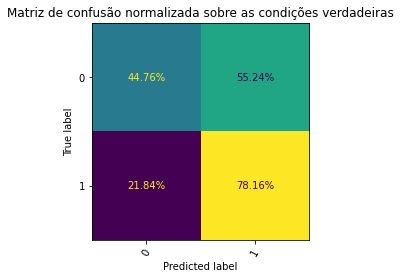

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
plt.show()

### LGBMClassifier

In [15]:
from lightgbm import LGBMClassifier

In [16]:
lgb_model = LGBMClassifier(n_jobs=-1, random_state=0)
lgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)

accuracy_score(y_test, lgb_preds)*100

77.83414312772791

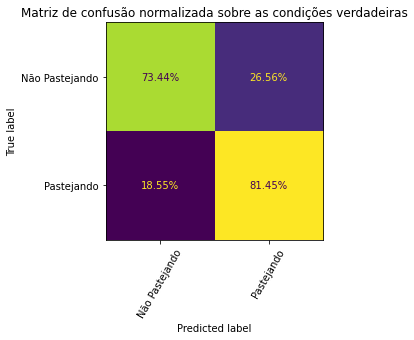

In [17]:
imprimeMatrizDeConfusão(y_test, lgb_preds, lgb_model)

#### LGB: Busca de melhores hiper parâmetros

In [95]:
def tune_lgb(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    lgb_Model = LGBMClassifier(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1, 
                         n_estimators=100, n_jobs=-1)
    
    auc = cross_val_score(lgb_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 512), # num_leaves
         (1, 500), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample bytree

In [51]:
%%time
resultados_lgb = gp_minimize(tune_lgb, space, random_state=0, verbose=1, n_calls=50, n_random_starts=10, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[0.015335192657991574, 433, 429, 0.8548891518449193, 0.6612073271073752] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 29.7196
Function value obtained: -0.7125
Current minimum: -0.7125
Iteration No: 2 started. Evaluating function at random point.
[0.005871694001325899, 154, 29, 0.30902347985110756, 0.529898605589215] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 14.8425
Function value obtained: -0.6312
Current minimum: -0.7125
Iteration No: 3 started. Evaluating function at random point.
[0.04210536704211821, 247, 197, 0.8442748253605089, 0.40365654437554166] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 18.5394
Function value obtained: -0.7245
Current minimum: -0.7245
Iteration No: 4 started. Evaluating function at random point.
[0.01978535031094702, 190, 479, 0.1833332413920129, 0.8830785325225929] 

Iteration No: 4 ended. Evaluation done at random poi

In [52]:
resultados_lgb.x

[0.1, 512, 1, 1.0, 0.6446300002048094]

In [19]:
# Melhores hiper parâmetros para o conjunto PRO: learning_rate=0.1, num_leaves=512, min_child_samples=1, subsample=1.0, colsample_bytree=0.662, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

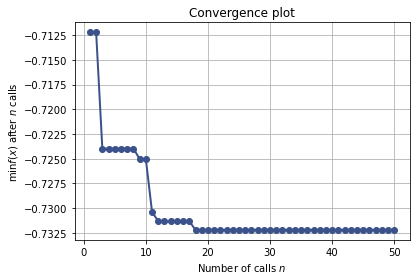

In [18]:
from skopt.plots import plot_convergence
plot_convergence(resultados_lgb)

In [36]:
# Melhores hiper parâmetros para o conjunto PNP: learning_rate=0.1, num_leaves=512, min_child_samples=88, subsample=0.729, colsample_bytree=0.671, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

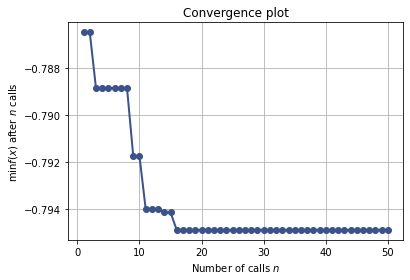

In [86]:
from skopt.plots import plot_convergence
plot_convergence(resultados_lgb)

#### LGB: Treinamento com os melhores hiper parâmetros

In [22]:
%%time
lgb_model = LGBMClassifier(learning_rate=0.1, num_leaves=512, min_child_samples=88, subsample=0.729, colsample_bytree=0.671, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1)
lgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)

accuracy_score(y_test, lgb_preds)*100

CPU times: user 25 s, sys: 124 ms, total: 25.1 s
Wall time: 3.56 s


79.76859095775343

In [23]:
classification_report_extendido(y_test, lgb_preds)

{'Não Pastejando': {'precision': 0.7978580726598556,
  'recall': 0.7385842873053258,
  'f1-score': 0.7670778303452069,
  'support': 54771,
  'specificity': 0.8462473184416208,
  'npv': 0.797562492930664},
 'Pastejando': {'precision': 0.797562492930664,
  'recall': 0.8462473184416208,
  'f1-score': 0.8211839548137743,
  'support': 66659,
  'specificity': 0.7385842873053258,
  'npv': 0.7978580726598556},
 'accuracy': 0.7976859095775344,
 'macro avg': {'precision': 0.7977102827952598,
  'recall': 0.7924158028734734,
  'f1-score': 0.7941308925794905,
  'support': 121430},
 'weighted avg': {'precision': 0.7976958141638647,
  'recall': 0.7976859095775344,
  'f1-score': 0.7967793880405888,
  'support': 121430}}

In [24]:
print(classification_report(y_test, lgb_preds, digits=3))

                precision    recall  f1-score   support

Não Pastejando      0.798     0.739     0.767     54771
    Pastejando      0.798     0.846     0.821     66659

      accuracy                          0.798    121430
     macro avg      0.798     0.792     0.794    121430
  weighted avg      0.798     0.798     0.797    121430



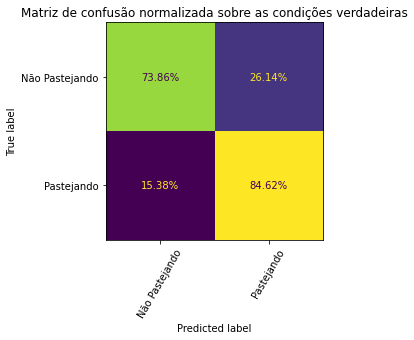

In [45]:
imprimeMatrizDeConfusão(y_test, lgb_preds, lgb_model)

In [217]:
lgb_preds = lgb_model.predict(X_train)

accuracy_score(y_train, lgb_preds)*100

82.02956435806638

### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

#### Com Randomized Search CV

In [39]:
rf_Model = RandomForestClassifier(random_state=0, n_jobs=-1)

In [40]:
# Create the param grid
rf_param_grid = {'n_estimators':  np.arange(50, 250, 50),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[50, 100, 150, None],
               'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 10, 30, 50],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [41]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = rf_param_grid, cv = 3, verbose=1, random_state=0)

In [ ]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [46]:
rf_RandomGrid.best_params_

{'n_estimators': 150,
 'min_samples_split': 30,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'criterion': 'entropy',
 'bootstrap': False}

In [48]:
rf_RandomGrid.best_score_

0.7361747363918738

In [50]:
preds_rf_RG = rf_RandomGrid.predict(X_test)

In [51]:
accuracy_score(y_test, preds_rf_RG)*100

74.09413128837589

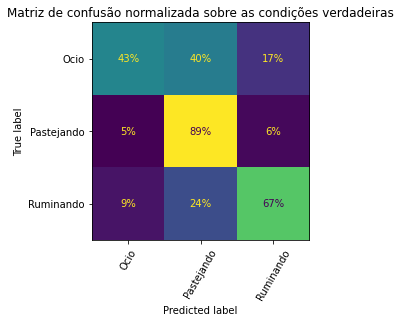

In [52]:
imprimeMatrizDeConfusão(y_test, preds_rf_RG, rf_RandomGrid)

#### RF: Busca de melhores hiper parâmetros

In [92]:
def tune_rf(params):
    n_estimators = params[0]
    max_features = params[1]
    max_depth = params[2]
    criterion = params[3]
    min_samples_split = params[4]
    min_samples_leaf = params[5]
    bootstrap = params[6]
    
    print(params, '\n')
    
    rf_Model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion, min_samples_split=min_samples_split,
                                       min_samples_leaf = min_samples_leaf, bootstrap=bootstrap, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(rf_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [ np.arange(50, 250, 50), # n_estimators
         ['auto', 'sqrt'], # max_features
         [50, 100, 150, None], # max_depth
         ['gini', 'entropy'], # criterion
         [2, 5, 10, 30, 50], # min_samples_split
         [1,2,4], # min_samples_leaf
         [True, False]] # bootstrap] 

In [93]:
%%time
from skopt import forest_minimize
resultado_rf = gp_minimize(tune_rf, space, random_state=0, verbose=1, n_calls=30, n_random_starts=15, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[150, 'sqrt', None, 'gini', 10, 2, False] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 118.0591
Function value obtained: -0.7941
Current minimum: -0.7941
Iteration No: 2 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 10, 2, True] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 31.4995
Function value obtained: -0.7960
Current minimum: -0.7960
Iteration No: 3 started. Evaluating function at random point.
[100, 'sqrt', 100, 'gini', 5, 4, False] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 78.5794
Function value obtained: -0.7949
Current minimum: -0.7960
Iteration No: 4 started. Evaluating function at random point.
[150, 'sqrt', 150, 'gini', 10, 2, True] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 85.1647
Function value obtained: -0.7974
Current minimum: -0.7974
Iteration No: 5 started. Evaluating function a

In [96]:
resultado_rf.x

[200, 'sqrt', 50, 'entropy', 30, 1, True]

In [63]:
# Melhores hiper parâmetros para o conjunto PRO: n_estimators=200, max_features='sqrt', max_depth=None, criterion='entropy', min_samples_split=10, min_samples_leaf=2 , bootstrap=True, random_state=0, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

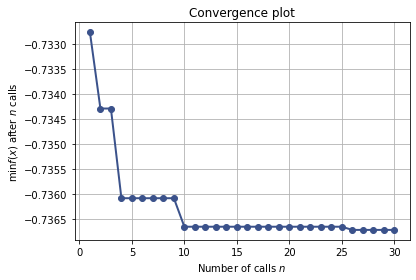

In [64]:
from skopt.plots import plot_convergence
plot_convergence(resultado_rf)

In [97]:
# Melhores hiper parâmetros para o conjunto PNP: n_estimators=200, max_features='sqrt', max_depth=50, criterion='entropy', min_samples_split=30, min_samples_leaf=1 , bootstrap=True, random_state=0, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

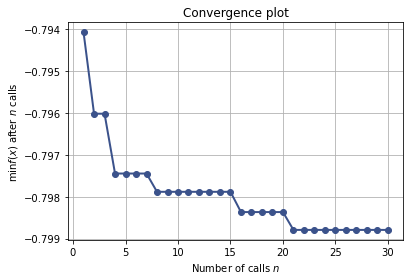

In [95]:
from skopt.plots import plot_convergence
plot_convergence(resultado_rf)

#### RF: Treinamento com os melhores hiper parâmetros

In [15]:
%%time
rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=50, criterion='entropy',
                                  min_samples_split=30, min_samples_leaf=1 , bootstrap=True, random_state=0, n_jobs=-1)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

CPU times: user 8min 38s, sys: 835 ms, total: 8min 38s
Wall time: 1min 10s


In [252]:
accuracy_score(y_test, preds)*100

80.1276455571111

In [17]:
classification_report_extendido(y_test, preds)

{'Não Pastejando': {'precision': 0.803534633063877,
  'recall': 0.7404648445345164,
  'f1-score': 0.7707115912697281,
  'support': 54771,
  'specificity': 0.8512428929326873,
  'npv': 0.7996702274584966},
 'Pastejando': {'precision': 0.7996702274584966,
  'recall': 0.8512428929326873,
  'f1-score': 0.8246510242193916,
  'support': 66659,
  'specificity': 0.7404648445345164,
  'npv': 0.803534633063877},
 'accuracy': 0.8012764555711109,
 'macro avg': {'precision': 0.8016024302611868,
  'recall': 0.7958538687336019,
  'f1-score': 0.7976813077445599,
  'support': 121430},
 'weighted avg': {'precision': 0.8014132675590673,
  'recall': 0.8012764555711109,
  'f1-score': 0.8003216436537486,
  'support': 121430}}

In [253]:
print(classification_report(y_test, preds, digits=3))

                precision    recall  f1-score   support

Não Pastejando      0.804     0.740     0.771     54771
    Pastejando      0.800     0.851     0.825     66659

      accuracy                          0.801    121430
     macro avg      0.802     0.796     0.798    121430
  weighted avg      0.801     0.801     0.800    121430



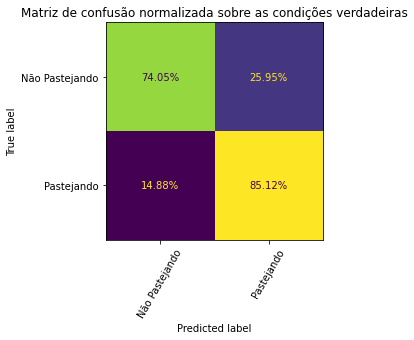

In [254]:
imprimeMatrizDeConfusão(y_test, preds, rf_model)

### Gradient Boosting

In [18]:
from xgboost import XGBClassifier

In [19]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

y_train_ordinal = ordinal_encoder.fit_transform(y_train.array.reshape(-1,1))
y_test_ordinal = ordinal_encoder.transform(y_test.array.reshape(-1,1))

In [109]:
xgb_model = XGBClassifier(use_label_encoder=False, random_state=0)
xgb_model.fit(X_train, y_train_ordinal)

[16:42:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [110]:
xgb_preds = xgb_model.predict(X_test)
xgb_preds = ordinal_encoder.inverse_transform(xgb_preds.reshape(-1,1))
accuracy_score(y_test, xgb_preds)*100

71.71539158362843

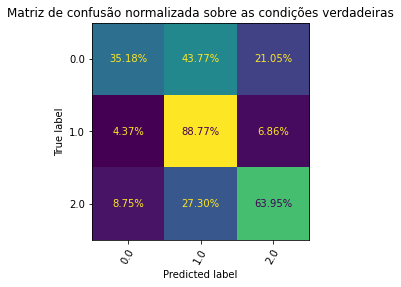

In [111]:
imprimeMatrizDeConfusão(y_test, xgb_preds, xgb_model)

#### GB: Busca de melhores hiper parâmetros

In [112]:
def tune_gb(params):
    learning_rate = params[0]
    max_depth = params[1]
    min_child_weight = params[2]
    gamma = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    gb_Model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight, colsample_bytree=colsample_bytree,
                             use_label_encoder=False, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(gb_Model, X_train, y_train_ordinal, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 16), # max_depth
         (1, 16), # min_child_weight
         (0.0, 0.5), # gamma
         (0.1, 1.0)] # colsample bytree

In [ ]:
%%time
resultados_gb = gp_minimize(tune_gb, space, random_state=0, verbose=1, n_calls=30, n_random_starts=10, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[0.015335192657991574, 14, 14, 0.4236258693920628, 0.6612073271073752] 

[16:43:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:44:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 244.4441
Function value obtained: -0.7

In [ ]:
resultados_gb.x

[0.1, 16, 1, 0.0, 0.5370264280766771]

In [ ]:
# Melhores hiper parâmetros para o conjunto PRO: learning_rate=0.1, max_depth=16, min_child_weight=1, gamma=0.0, colsample_bytree=0.5370264280766771, use_label_encoder=False, random_state=0, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

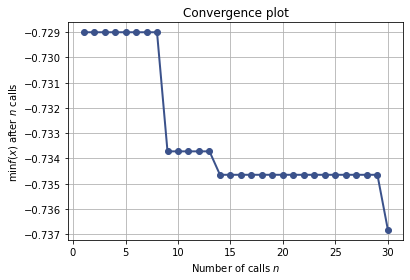

In [117]:
from skopt.plots import plot_convergence
plot_convergence(resultados_gb)

In [87]:
# Melhores hiper parâmetros para o conjunto PNP: learning_rate=0.008851671496973969, max_depth=16, min_child_weight=1, gamma=0.0, colsample_bytree=0.631278076735511, use_label_encoder=False, random_state=0, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

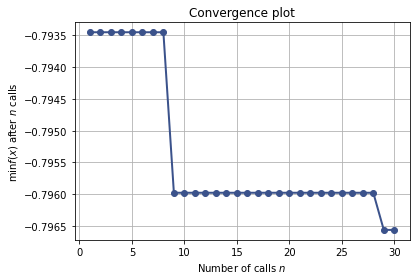

In [85]:
plot_convergence(resultados_gb)

#### GB: Treinamento com os melhores hiper parâmetros

In [20]:
%%time
gb_model = XGBClassifier(learning_rate=0.008851671496973969, max_depth=16, min_child_weight=1, gamma=0.0, 
                         colsample_bytree=0.631278076735511, use_label_encoder=False, random_state=0, n_jobs=-1)

gb_model.fit(X_train, y_train_ordinal)
preds = gb_model.predict(X_test)

[11:35:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 6min 21s, sys: 3.86 s, total: 6min 25s
Wall time: 52.8 s


In [21]:
preds = ordinal_encoder.inverse_transform(preds.reshape(-1,1))
accuracy_score(y_test, preds)*100

80.01152927612615

In [23]:
classification_report_extendido(y_test, preds)

{'Não Pastejando': {'precision': 0.8023474829985923,
  'recall': 0.7388581548629749,
  'f1-score': 0.7692951106379742,
  'support': 54771,
  'specificity': array([0.8504478]),
  'npv': array([0.79852943])},
 'Pastejando': {'precision': 0.7985294324792586,
  'recall': 0.8504478014971721,
  'f1-score': 0.8236712870136287,
  'support': 66659,
  'specificity': array([0.73885815]),
  'npv': array([0.80234748])},
 'accuracy': 0.8001152927612616,
 'macro avg': {'precision': 0.8004384577389254,
  'recall': 0.7946529781800735,
  'f1-score': 0.7964831988258014,
  'support': 121430},
 'weighted avg': {'precision': 0.8002515641188405,
  'recall': 0.8001152927612616,
  'f1-score': 0.7991449133310874,
  'support': 121430}}

In [272]:
print(classification_report(y_test, preds, digits=3))

                precision    recall  f1-score   support

Não Pastejando      0.802     0.739     0.769     54771
    Pastejando      0.799     0.850     0.824     66659

      accuracy                          0.800    121430
     macro avg      0.800     0.795     0.796    121430
  weighted avg      0.800     0.800     0.799    121430



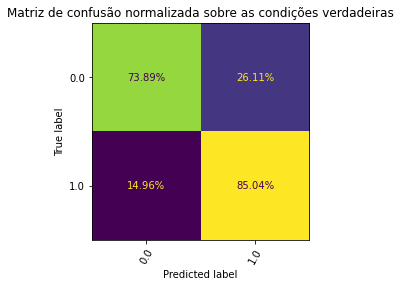

In [273]:
imprimeMatrizDeConfusão(y_test, preds, gb_model)

### SVM

In [21]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state = 0)

In [ ]:
%%time
svc_model = SVC(kernel='linear', cache_size=5000, random_state=0) # Linear Kernel

svc_model.fit(X_train, y_train)

svc_preds = svc_model.predict(X_test)

In [ ]:
print("Acurácia:", accuracy_score(y_test, svc_preds))

###  Gaussian Naive Bayes

In [105]:
# Conjunto com todas as classes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [106]:
from sklearn.naive_bayes import GaussianNB

In [107]:
gnb_model = GaussianNB()
gnb_preds = gnb_model.fit(X_train, y_train).predict(X_test)
print("Acurácia:", accuracy_score(y_test, gnb_preds))

Acurácia: 0.5575803093788705


### Logistic Regression

In [114]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y_pnp = y
y_pnp = y_pnp.replace(to_replace=['Agua', 'Locomovendo', 'Ocio', 'Outros','Ruminando'], value='Não Pastejando')
X_train, X_test, y_train, y_test = train_test_split(X, y_pnp, random_state = 0)

In [118]:
from sklearn.linear_model import LogisticRegression

In [128]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [129]:
lr_preds = lr_model.predict(X_test)

In [130]:
print("Acurácia:", accuracy_score(y_test, lr_preds))

Acurácia: 0.6313740216617915


### Redes Neurais

In [24]:
from sklearn.neural_network import MLPClassifier

In [176]:
rn_model = MLPClassifier(random_state=0)
rn_model.fit(X_train, y_train.values)

MLPClassifier(random_state=0)

In [177]:
rn_preds = rn_model.predict(X_test)

In [178]:
print("Acurácia:", accuracy_score(y_test, rn_preds)*100)

Acurácia: 78.25166762743969


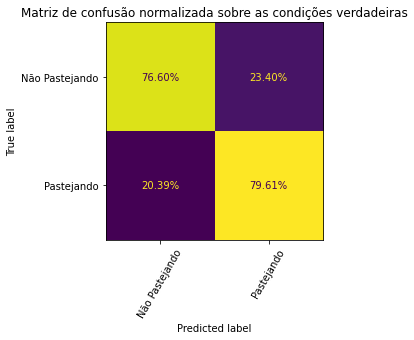

In [179]:
imprimeMatrizDeConfusão(y_test, rn_preds, rn_model)

#### RN: Busca de melhores hiper parâmetros 

In [25]:
rn_model = MLPClassifier(hidden_layer_sizes=(20,30,30,20), activation="tanh", verbose=0, random_state=0)

In [26]:
%%time
rn_model.fit(X_train, y_train.values)

CPU times: user 19min 40s, sys: 14.8 s, total: 19min 55s
Wall time: 5min


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 30, 30, 20),
              random_state=0, verbose=0)

In [27]:
rn_preds = rn_model.predict(X_test)

In [20]:
print("Acurácia:", accuracy_score(y_test, rn_preds)*100)

Acurácia: 79.21106810508111


In [28]:
classification_report_extendido(y_test, rn_preds)

{'Não Pastejando': {'precision': 0.7851582871380836,
  'recall': 0.7421810812291176,
  'f1-score': 0.7630650247784952,
  'support': 54771,
  'specificity': 0.8331358106182211,
  'npv': 0.7972780912183988},
 'Pastejando': {'precision': 0.7972780912183988,
  'recall': 0.8331358106182211,
  'f1-score': 0.8148126412159981,
  'support': 66659,
  'specificity': 0.7421810812291176,
  'npv': 0.7851582871380836},
 'accuracy': 0.7921106810508112,
 'macro avg': {'precision': 0.7912181891782412,
  'recall': 0.7876584459236693,
  'f1-score': 0.7889388329972467,
  'support': 121430},
 'weighted avg': {'precision': 0.791811453737686,
  'recall': 0.7921106810508112,
  'f1-score': 0.7914718794610901,
  'support': 121430}}

In [21]:
print(classification_report(y_test, rn_preds, digits=3))

                precision    recall  f1-score   support

Não Pastejando      0.785     0.742     0.763     54771
    Pastejando      0.797     0.833     0.815     66659

      accuracy                          0.792    121430
     macro avg      0.791     0.788     0.789    121430
  weighted avg      0.792     0.792     0.791    121430



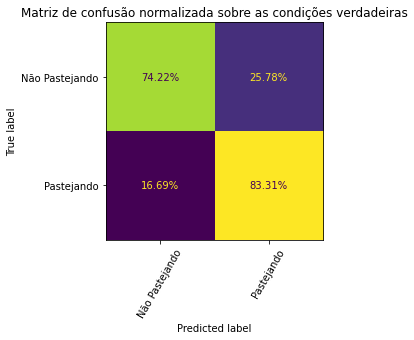

In [22]:
imprimeMatrizDeConfusão(y_test, rn_preds, rn_model)

### KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
knn_model = KNeighborsClassifier(n_neighbors=10,  weights='distance', n_jobs=-1)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10, weights='distance')

In [31]:
knn_preds = knn_model.predict(X_test)

print("Acurácia:", accuracy_score(y_test, knn_preds))

Acurácia: 0.7988470723873837


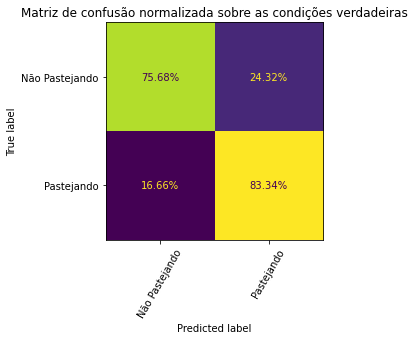

In [32]:
imprimeMatrizDeConfusão(y_test, knn_preds, knn_model)

#### KNN: Busca de melhores hiper parâmetros

In [56]:
def tune_knn(params):
    n_neighbors = params[0]
    weights = params[1]
    leaf_size = params[2]
    p = params[3]
    
    print(params, '\n')
    
    knn_Model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, leaf_size=leaf_size, p=p, n_jobs=-1)
    
    knn_Model.fit(X_train, y_train)
    
    preds = knn_Model.predict(X_test)
    
    return -accuracy_score(y_test, preds)

space = [(5, 50), #n_neighbors
         ['uniform', 'distance'], # weights
         [20,30,40,50,100], # leaf_size
         [1,2]] # p

In [ ]:
%%time
resultados_knn = gp_minimize(tune_knn, space, random_state=0, verbose=1, n_calls=30, n_random_starts=10, n_jobs=-1)

In [58]:
resultados_knn.x

[50, 'distance', 20, 2]

In [59]:
# Melhores hiper parâmetros para o conjunto PRO: n_neighbors=37, weights='distance', leaf_size=20, p=1, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

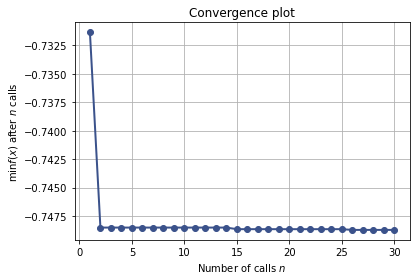

In [52]:
from skopt.plots import plot_convergence
plot_convergence(resultados_knn)

In [97]:
# Melhores hiper parâmetros para o conjunto PNP: n_neighbors=46, weights='distance', leaf_size=20, p=2, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

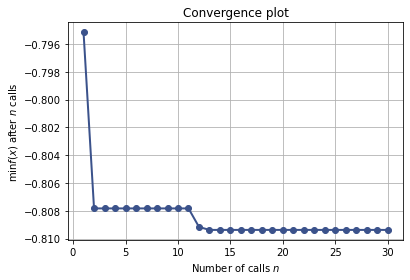

In [60]:
from skopt.plots import plot_convergence
plot_convergence(resultados_knn)

#### KNN: Treinamento com os melhores hiper parâmetros

In [33]:
%%time
knn_model = KNeighborsClassifier(n_neighbors=46, weights='distance', leaf_size=20, p=2, n_jobs=-1)

knn_model.fit(X_train, y_train)
preds = knn_model.predict(X_test)

CPU times: user 33.3 s, sys: 95.6 ms, total: 33.4 s
Wall time: 6.18 s


In [219]:
accuracy_score(y_test, preds)*100

80.89104834060777

In [34]:
classification_report_extendido(y_test, preds)

{'Não Pastejando': {'precision': 0.8002320671092428,
  'recall': 0.7680889521827244,
  'f1-score': 0.7838311192263979,
  'support': 54771,
  'specificity': 0.8424518819664262,
  'npv': 0.815536095499499},
 'Pastejando': {'precision': 0.815536095499499,
  'recall': 0.8424518819664262,
  'f1-score': 0.8287755132159565,
  'support': 66659,
  'specificity': 0.7680889521827244,
  'npv': 0.8002320671092428},
 'accuracy': 0.8089104834060776,
 'macro avg': {'precision': 0.8078840813043708,
  'recall': 0.8052704170745753,
  'f1-score': 0.8063033162211772,
  'support': 121430},
 'weighted avg': {'precision': 0.8086332136831216,
  'recall': 0.8089104834060776,
  'f1-score': 0.808503344862155,
  'support': 121430}}

In [220]:
print(classification_report(y_test, preds, digits=3))

                precision    recall  f1-score   support

Não Pastejando      0.800     0.768     0.784     54771
    Pastejando      0.816     0.842     0.829     66659

      accuracy                          0.809    121430
     macro avg      0.808     0.805     0.806    121430
  weighted avg      0.809     0.809     0.809    121430



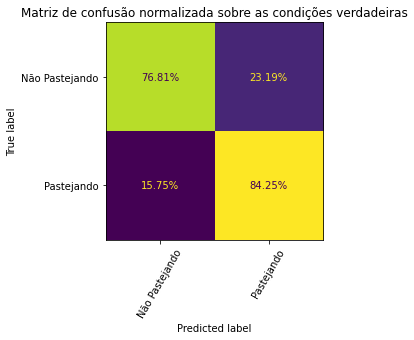

In [221]:
imprimeMatrizDeConfusão(y_test, preds, knn_model)

### Validação Exeterna com os dados do Leonardo

Leitura dos bancos de dados em DataFrame Pandas. 

In [141]:
caminho_dados_leo = 'Datasets/Leonardo/dados_pre_processados_leonardo.csv'

In [142]:
df_leo = pd.read_csv(caminho_dados_leo)

In [143]:
df_leo.head()

,SensorID,Date,Value,Voltage,X,Y,Z,Comportamento,Season_fall,Season_spring,Season_summer,magn,sma,ent,erg,pit,rol,icl
0,175810,2019-01-21 08:15:03,1.115,3.04,-0.171,1.115,0.242,Pastejando,0,0,1,1.153703,1.528,7.474426,1.771641,-12.108253,-8.719130,-81.476304
1,175810,2019-01-21 08:16:04,0.583,3.02,-0.702,0.071,0.583,Pastejando,0,0,1,0.915278,1.356,-0.089163,0.701798,-39.565868,-84.224766,-39.916535
2,175810,2019-01-21 08:16:05,0.683,3.01,-0.594,-0.026,0.683,Pastejando,0,0,1,0.905539,1.303,0.138071,0.672402,-48.959606,-92.506296,-49.007300
3,175810,2019-01-21 08:16:06,0.631,3.01,-0.706,0.059,0.631,Pastejando,0,0,1,0.948724,1.396,-0.031235,0.810140,-41.690272,-85.222926,-41.913249
4,175810,2019-01-21 08:16:07,0.604,3.01,-0.805,0.081,0.604,Pastejando,0,0,1,1.009654,1.490,-0.197988,1.039180,-36.742843,-84.254174,-37.126721


In [144]:
# Seleciona os abributos correspondentes da lista features_aplicaveis
df_leo = df_leo[features_aplicaveis]

In [145]:
df_leo = df_leo.rename({'X': 'a', 'Y': 'b', 'Z': 'c'}, axis=1)  

In [146]:
df_leo = df_leo.rename({'a': 'Y', 'b': 'Z', 'c': 'X'}, axis=1)  

In [147]:
df_leo = df_leo[features_aplicaveis]

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [148]:
y = df_leo.Comportamento
X = df_leo.drop('Comportamento', axis=1)
y = y.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')

In [149]:
# Para reescalar os dados
X_season = X[['Season_fall', 'Season_spring', 'Season_summer']]

X.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)

columns = X.columns
index = X.index

X = sc.transform(X)

X = pd.DataFrame(X, columns=columns, index=index)

X = pd.concat([X, X_season], axis=1)

#### Com LGBMClassifier

In [94]:
%%time
lgb_preds = lgb_model.predict(X)

accuracy_score(y, lgb_preds)*100

CPU times: user 3.34 s, sys: 47.7 ms, total: 3.39 s
Wall time: 579 ms


56.711199361146484

In [96]:
classification_report_extendido(y, lgb_preds)

{'Não Pastejando': {'precision': 0.6621931260229132,
  'recall': 0.5429348687982628,
  'f1-score': 0.596663158670894,
  'support': 81973,
  'specificity': 0.6018658155928874,
  'npv': 0.4780955299558428},
 'Pastejando': {'precision': 0.4780955299558428,
  'recall': 0.6018658155928874,
  'f1-score': 0.5328882505919341,
  'support': 57026,
  'specificity': 0.5429348687982628,
  'npv': 0.6621931260229132},
 'accuracy': 0.5671119936114648,
 'macro avg': {'precision': 0.5701443279893781,
  'recall': 0.5724003421955751,
  'f1-score': 0.5647757046314141,
  'support': 138999},
 'weighted avg': {'precision': 0.5866648883138594,
  'recall': 0.5671119936114648,
  'f1-score': 0.5704987408829187,
  'support': 138999}}

In [233]:
print(classification_report(y, lgb_preds, digits=3))

                precision    recall  f1-score   support

Não Pastejando      0.662     0.543     0.597     81973
    Pastejando      0.478     0.602     0.533     57026

      accuracy                          0.567    138999
     macro avg      0.570     0.572     0.565    138999
  weighted avg      0.587     0.567     0.570    138999



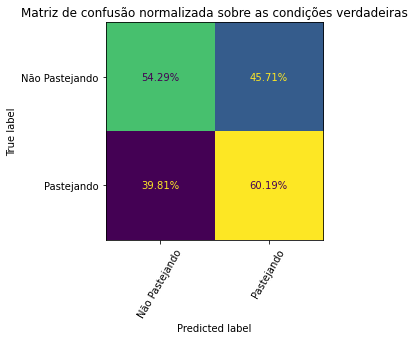

In [234]:
imprimeMatrizDeConfusão(y, lgb_preds, lgb_model)

#### Com RF

In [97]:
%%time
preds = rf_model.predict(X)

CPU times: user 3.76 s, sys: 24.5 ms, total: 3.79 s
Wall time: 578 ms


In [98]:
accuracy_score(y, preds)*100

56.797530917488615

In [99]:
classification_report_extendido(y, preds)

{'Não Pastejando': {'precision': 0.6632850673340484,
  'recall': 0.5431666524343381,
  'f1-score': 0.5972461619975721,
  'support': 81973,
  'specificity': 0.6036369375372637,
  'npv': 0.4789553505586398},
 'Pastejando': {'precision': 0.4789553505586398,
  'recall': 0.6036369375372637,
  'f1-score': 0.5341163875032002,
  'support': 57026,
  'specificity': 0.5431666524343381,
  'npv': 0.6632850673340484},
 'accuracy': 0.5679753091748861,
 'macro avg': {'precision': 0.5711202089463441,
  'recall': 0.5734017949858009,
  'f1-score': 0.5656812747503861,
  'support': 138999},
 'weighted avg': {'precision': 0.5876615993318725,
  'recall': 0.5679753091748861,
  'f1-score': 0.5713464179683628,
  'support': 138999}}

In [286]:
print(classification_report(y, preds, digits=3))

                precision    recall  f1-score   support

Não Pastejando      0.663     0.543     0.597     81973
    Pastejando      0.479     0.604     0.534     57026

      accuracy                          0.568    138999
     macro avg      0.571     0.573     0.566    138999
  weighted avg      0.588     0.568     0.571    138999



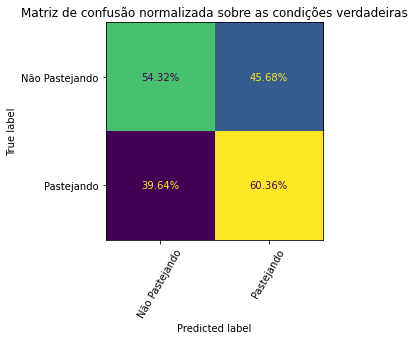

In [287]:
imprimeMatrizDeConfusão(y, preds, rf_model)

#### Com Gradient Boosting

In [100]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

y_ordinal = ordinal_encoder.fit_transform(y.array.reshape(-1,1))

In [101]:
%%time
preds = gb_model.predict(X)

CPU times: user 2.62 s, sys: 35.6 ms, total: 2.66 s
Wall time: 373 ms


In [103]:
preds = ordinal_encoder.inverse_transform(preds.reshape(-1,1))
accuracy_score(y, preds)*100

55.88745242771531

In [104]:
classification_report_extendido(y, preds)

{'Não Pastejando': {'precision': 0.655327468230694,
  'recall': 0.5315896697693143,
  'f1-score': 0.5870086483282593,
  'support': 81973,
  'specificity': array([0.59809561]),
  'npv': array([0.47041543])},
 'Pastejando': {'precision': 0.4704154253558424,
  'recall': 0.5980956055132747,
  'f1-score': 0.5266270362078284,
  'support': 57026,
  'specificity': array([0.53158967]),
  'npv': array([0.65532747])},
 'accuracy': 0.5588745242771531,
 'macro avg': {'precision': 0.5628714467932682,
  'recall': 0.5648426376412945,
  'f1-score': 0.5568178422680439,
  'support': 138999},
 'weighted avg': {'precision': 0.5794650939907262,
  'recall': 0.5588745242771531,
  'f1-score': 0.5622363707379191,
  'support': 138999}}

In [291]:
print(classification_report(y, preds, digits=3))

                precision    recall  f1-score   support

Não Pastejando      0.655     0.532     0.587     81973
    Pastejando      0.470     0.598     0.527     57026

      accuracy                          0.559    138999
     macro avg      0.563     0.565     0.557    138999
  weighted avg      0.579     0.559     0.562    138999



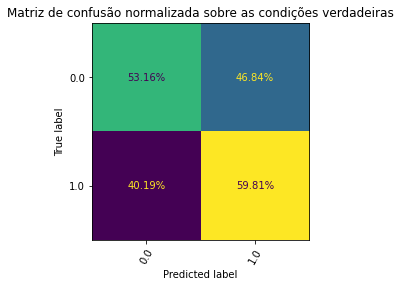

In [292]:
imprimeMatrizDeConfusão(y, preds, gb_model)

#### Com KNN

In [105]:
%%time

preds = knn_model.predict(X)

CPU times: user 3min 19s, sys: 235 ms, total: 3min 19s
Wall time: 31.3 s


In [236]:
accuracy_score(y, preds)*100

52.03202900740293

In [106]:
classification_report_extendido(y, preds)

{'Não Pastejando': {'precision': 0.6253276969458644,
  'recall': 0.46558013004281895,
  'f1-score': 0.5337575609244432,
  'support': 81973,
  'specificity': 0.5990074702767159,
  'npv': 0.438121256429002},
 'Pastejando': {'precision': 0.438121256429002,
  'recall': 0.5990074702767159,
  'f1-score': 0.5060855007296675,
  'support': 57026,
  'specificity': 0.46558013004281895,
  'npv': 0.6253276969458644},
 'accuracy': 0.5203202900740294,
 'macro avg': {'precision': 0.5317244766874332,
  'recall': 0.5322938001597675,
  'f1-score': 0.5199215308270553,
  'support': 138999},
 'weighted avg': {'precision': 0.5485240186682179,
  'recall': 0.5203202900740294,
  'f1-score': 0.5224047677053029,
  'support': 138999}}

In [237]:
print(classification_report(y, preds, digits=3))

                precision    recall  f1-score   support

Não Pastejando      0.625     0.466     0.534     81973
    Pastejando      0.438     0.599     0.506     57026

      accuracy                          0.520    138999
     macro avg      0.532     0.532     0.520    138999
  weighted avg      0.549     0.520     0.522    138999



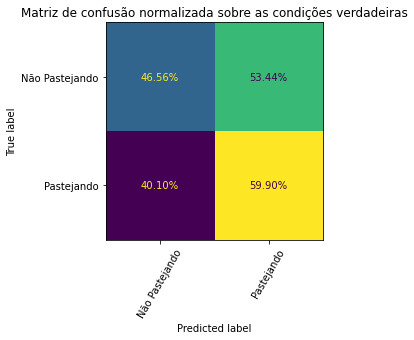

In [238]:
imprimeMatrizDeConfusão(y, preds, knn_model)

#### Com RN

In [107]:
%%time
preds = rn_model.predict(X)

CPU times: user 1.32 s, sys: 27.9 ms, total: 1.35 s
Wall time: 343 ms


In [33]:
accuracy_score(y, preds)*100

53.903265491118646

In [108]:
classification_report_extendido(y, preds)

{'Não Pastejando': {'precision': 0.658333775631159,
  'recall': 0.4539421516840911,
  'f1-score': 0.5373584796672828,
  'support': 81973,
  'specificity': 0.6613474555465928,
  'npv': 0.45727241864299917},
 'Pastejando': {'precision': 0.45727241864299917,
  'recall': 0.6613474555465928,
  'f1-score': 0.5406947570644148,
  'support': 57026,
  'specificity': 0.4539421516840911,
  'npv': 0.658333775631159},
 'accuracy': 0.5390326549111865,
 'macro avg': {'precision': 0.5578030971370791,
  'recall': 0.557644803615342,
  'f1-score': 0.5390266183658488,
  'support': 138999},
 'weighted avg': {'precision': 0.5758459523834608,
  'recall': 0.5390326549111865,
  'f1-score': 0.5387272273190562,
  'support': 138999}}

In [34]:
print(classification_report(y, preds, digits=3))

                precision    recall  f1-score   support

Não Pastejando      0.658     0.454     0.537     81973
    Pastejando      0.457     0.661     0.541     57026

      accuracy                          0.539    138999
     macro avg      0.558     0.558     0.539    138999
  weighted avg      0.576     0.539     0.539    138999



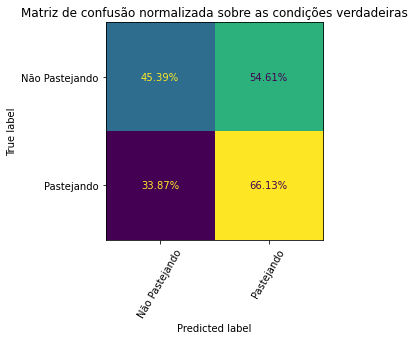

In [35]:
imprimeMatrizDeConfusão(y, preds, rn_model)

#### Com GLM

In [150]:
df = pd.concat([X, y], axis=1)

In [151]:
y, X = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df, return_type='dataframe')

In [152]:
%%time
preds = glm_results.predict(X)

CPU times: user 9.53 ms, sys: 13 µs, total: 9.54 ms
Wall time: 8.13 ms


In [153]:
preds[2] = preds.median(axis=1)

In [154]:
preds = preds.reset_index(drop=True)

In [155]:
b = np.zeros((preds.shape[0], 2))

In [156]:
for i in range(preds.shape[0]):
    for j in range(2):
        if preds.loc[i,j] > preds.loc[i,2]:
            b[i,j] = 1
        else:
            b[i,j] = 0

In [157]:
preds = pd.DataFrame(b, columns=['Não Pastejando', 'Pastejando'])

In [158]:
accuracy_score(y, preds)*100

43.332685846660766

In [159]:
print(classification_report(y, preds, digits=3))

              precision    recall  f1-score   support

           0      0.535     0.300     0.384     81973
           1      0.383     0.625     0.475     57026

   micro avg      0.433     0.433     0.433    138999
   macro avg      0.459     0.463     0.430    138999
weighted avg      0.473     0.433     0.422    138999
 samples avg      0.433     0.433     0.433    138999



In [160]:
# Reverso de get_dummies
preds = preds.idxmax(axis=1)

In [161]:
y = y.rename(columns={"Comportamento[Não Pastejando]" : "Não Pastejando", "Comportamento[Pastejando]" : "Pastejando"})

In [162]:
y = y.idxmax(axis=1)

In [163]:
y = y.reset_index(drop=True)

In [164]:
classification_report_extendido(y, preds)

{'Não Pastejando': {'precision': 0.5348705677615836,
  'recall': 0.29995242335891087,
  'f1-score': 0.38435865971565464,
  'support': 81973,
  'specificity': 0.6250482236172974,
  'npv': 0.38314934052822236},
 'Pastejando': {'precision': 0.38314934052822236,
  'recall': 0.6250482236172974,
  'f1-score': 0.4750791376495285,
  'support': 57026,
  'specificity': 0.29995242335891087,
  'npv': 0.5348705677615836},
 'accuracy': 0.4333268584666077,
 'macro avg': {'precision': 0.459009954144903,
  'recall': 0.4625003234881041,
  'f1-score': 0.4297188986825916,
  'support': 138999},
 'weighted avg': {'precision': 0.47262512208060986,
  'recall': 0.4333268584666077,
  'f1-score': 0.4215778193834011,
  'support': 138999}}

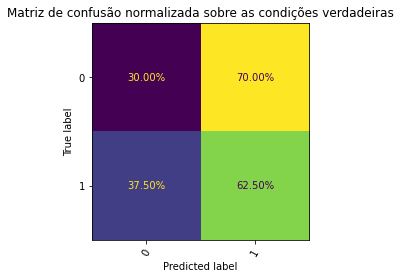

In [162]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
plt.show()

### Teste de RF em CV

In [22]:
from sklearn.model_selection import cross_val_score

def get_score(n_estimators):
    clf = RandomForestClassifier(n_estimators, random_state=0, n_jobs=-1)
    scores = cross_val_score(clf, X_train, y_train, cv=3)
    return scores.mean()


In [14]:
results = {} 
n_estimators = 100
while n_estimators < 250:
    n_estimators += 50
    results[n_estimators] = get_score(n_estimators)

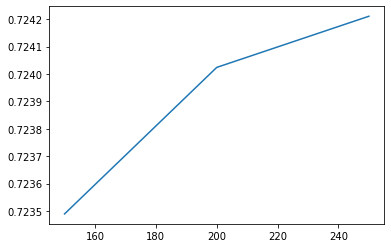

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

### Lidando com dados desbalanceados

In [76]:
import seaborn as sns

In [77]:
df = df.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')

In [78]:
df.Comportamento.value_counts()

Pastejando        332512
Não Pastejando    274638
Name: Comportamento, dtype: int64

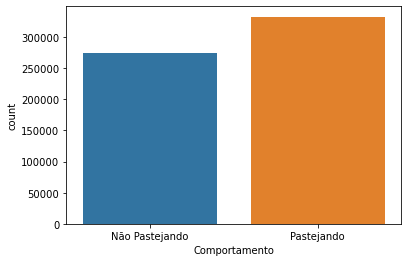

In [79]:
ax = sns.countplot(x="Comportamento", data=df)

In [80]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150,
                              min_samples_split=30,
                              min_samples_leaf=1,
                              max_features='sqrt',
                              max_depth=100,
                              criterion='entropy',
                              bootstrap=False,
                              n_jobs=-1,
                              random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [81]:
accuracy_score(y_test, preds)*100

80.98655086132229

In [82]:
print (classification_report(y_test, preds))

                precision    recall  f1-score   support

Não Pastejando       0.82      0.79      0.81     83061
    Pastejando       0.80      0.83      0.81     83195

      accuracy                           0.81    166256
     macro avg       0.81      0.81      0.81    166256
  weighted avg       0.81      0.81      0.81    166256



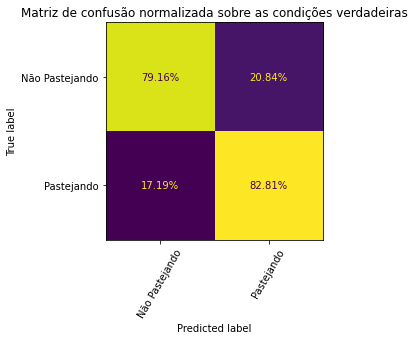

In [83]:
imprimeMatrizDeConfusão(y_test, preds, model)

#### Aplicando NearMiss

In [84]:
from imblearn.under_sampling import NearMiss
nr = NearMiss()

In [85]:
X = df.drop("Comportamento", axis = 1)
y = df.Comportamento

In [86]:
X, y = nr.fit_resample(X, y)

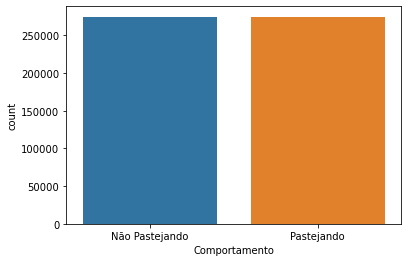

In [87]:
ax = sns.countplot(x=y)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [89]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [90]:
accuracy_score(y_test, preds)*100

79.49446180062483

In [91]:
print (classification_report(y_test, preds))

                precision    recall  f1-score   support

Não Pastejando       0.81      0.78      0.79     68649
    Pastejando       0.78      0.81      0.80     68670

      accuracy                           0.79    137319
     macro avg       0.80      0.79      0.79    137319
  weighted avg       0.80      0.79      0.79    137319



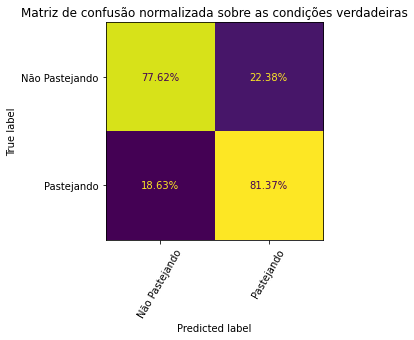

In [92]:
imprimeMatrizDeConfusão(y_test, preds, model)

#### Aplicando o SMOTE

In [93]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()

In [94]:
X = df.drop("Comportamento", axis = 1)
y = df.Comportamento

In [95]:
# Visualizando a quantidade de dados por classe
y.value_counts()

Pastejando        332512
Não Pastejando    274638
Name: Comportamento, dtype: int64

In [96]:
X, y = smt.fit_resample(X, y)

In [97]:
# Visualizando a quantidade de dados por classe
y.value_counts()

Não Pastejando    332512
Pastejando        332512
Name: Comportamento, dtype: int64

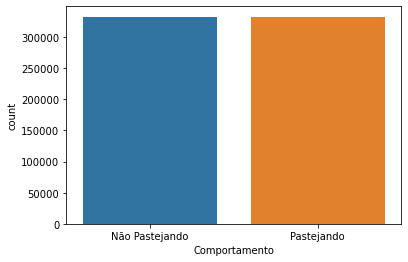

In [98]:
ax = sns.countplot(x=y)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [100]:
# Para reescalar os dados
from sklearn.preprocessing import StandardScaler

X_train_season = X_train[['Season_fall', 'Season_spring', 'Season_summer']]
X_test_season =  X_test[['Season_fall', 'Season_spring', 'Season_summer']]

X_train.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)
X_test.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)

columns = X_train.columns
index_train = X_train.index
index_test = X_test.index


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

X_train = pd.DataFrame(X_train, columns=columns, index=index_train)
X_test = pd.DataFrame(X_test, columns=columns, index=index_test)

X_train = pd.concat([X_train, X_train_season], axis=1)
X_test = pd.concat([X_test, X_test_season], axis=1)

In [101]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150,
                              min_samples_split=30,
                              min_samples_leaf=1,
                              max_features='sqrt',
                              max_depth=100,
                              criterion='entropy',
                              bootstrap=False,
                              n_jobs=-1,
                              random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [102]:
accuracy_score(y_test, preds)*100

80.98594937927052

In [103]:
print (classification_report(y_test, preds))

                precision    recall  f1-score   support

Não Pastejando       0.82      0.79      0.81     83061
    Pastejando       0.80      0.83      0.81     83195

      accuracy                           0.81    166256
     macro avg       0.81      0.81      0.81    166256
  weighted avg       0.81      0.81      0.81    166256



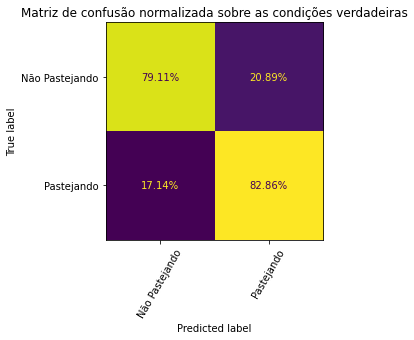

In [104]:
imprimeMatrizDeConfusão(y_test, preds, model)

### Treinamento e validação variando o tamanho do conjunto de dados

In [51]:
fracoes = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] # Frações testadas

df_amostras = {}
for fracao in fracoes:
    df_amostras[fracao] = df.sample(frac=fracao, random_state=0)

In [52]:
def amostrarEvalidar(df_amostras, model):
    print("Nome do modelo: ", type(model).__name__)
    for fracao in df_amostras:
        y = df_amostras[fracao].Comportamento
        X = df_amostras[fracao].drop('Comportamento', axis=1)
        y = y.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0)
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        print("Parcela usada:", fracao*100,"%", " Acurácia:",accuracy_score(y_test, preds)*100)
        print(classification_report(y_test, preds, digits=4))
        print('\n')

#### Random Forest

In [125]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=0, n_jobs=-1)
amostrarEvalidar(df_amostras, rf_model)

Nome do modelo:  RandomForestClassifier
Parcela usada: 0.1 %  Acurácia: 68.85245901639344
                precision    recall  f1-score   support

Não Pastejando     0.6491    0.6727    0.6607        55
    Pastejando     0.7231    0.7015    0.7121        67

      accuracy                         0.6885       122
     macro avg     0.6861    0.6871    0.6864       122
  weighted avg     0.6897    0.6885    0.6889       122



Parcela usada: 0.5 %  Acurácia: 74.01315789473685
                precision    recall  f1-score   support

Não Pastejando     0.7122    0.7070    0.7096       273
    Pastejando     0.7626    0.7672    0.7649       335

      accuracy                         0.7401       608
     macro avg     0.7374    0.7371    0.7372       608
  weighted avg     0.7400    0.7401    0.7400       608



Parcela usada: 1.0 %  Acurácia: 75.96707818930041
                precision    recall  f1-score   support

Não Pastejando     0.7470    0.6944    0.7198       540
    Pastejando 

#### LGBMClassifier

In [126]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(n_jobs=-1, random_state=0)
amostrarEvalidar(df_amostras, lgb_model)

Nome do modelo:  LGBMClassifier
Parcela usada: 0.1 %  Acurácia: 71.31147540983606
                precision    recall  f1-score   support

Não Pastejando     0.6724    0.7091    0.6903        55
    Pastejando     0.7500    0.7164    0.7328        67

      accuracy                         0.7131       122
     macro avg     0.7112    0.7128    0.7115       122
  weighted avg     0.7150    0.7131    0.7136       122



Parcela usada: 0.5 %  Acurácia: 72.5328947368421
                precision    recall  f1-score   support

Não Pastejando     0.6866    0.7143    0.7002       273
    Pastejando     0.7593    0.7343    0.7466       335

      accuracy                         0.7253       608
     macro avg     0.7229    0.7243    0.7234       608
  weighted avg     0.7266    0.7253    0.7257       608



Parcela usada: 1.0 %  Acurácia: 76.13168724279835
                precision    recall  f1-score   support

Não Pastejando     0.7367    0.7204    0.7285       540
    Pastejando     0.780

#### KNN

In [127]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_jobs=-1)
amostrarEvalidar(df_amostras, knn_model)

Nome do modelo:  KNeighborsClassifier
Parcela usada: 0.1 %  Acurácia: 63.934426229508205
                precision    recall  f1-score   support

Não Pastejando     0.6038    0.5818    0.5926        55
    Pastejando     0.6667    0.6866    0.6765        67

      accuracy                         0.6393       122
     macro avg     0.6352    0.6342    0.6345       122
  weighted avg     0.6383    0.6393    0.6387       122



Parcela usada: 0.5 %  Acurácia: 65.29605263157895
                precision    recall  f1-score   support

Não Pastejando     0.6092    0.6337    0.6212       273
    Pastejando     0.6914    0.6687    0.6798       335

      accuracy                         0.6530       608
     macro avg     0.6503    0.6512    0.6505       608
  weighted avg     0.6544    0.6530    0.6535       608



Parcela usada: 1.0 %  Acurácia: 64.60905349794238
                precision    recall  f1-score   support

Não Pastejando     0.6030    0.5963    0.5996       540
    Pastejando  

#### Redes Neurais

In [129]:
%%capture --no-stdout

from sklearn.neural_network import MLPClassifier

rn_model = MLPClassifier(random_state=0)
amostrarEvalidar(df_amostras, rn_model)

Nome do modelo:  MLPClassifier
Parcela usada: 0.1 %  Acurácia: 63.934426229508205
                precision    recall  f1-score   support

Não Pastejando     0.6038    0.5818    0.5926        55
    Pastejando     0.6667    0.6866    0.6765        67

      accuracy                         0.6393       122
     macro avg     0.6352    0.6342    0.6345       122
  weighted avg     0.6383    0.6393    0.6387       122



Parcela usada: 0.5 %  Acurácia: 64.47368421052632
                precision    recall  f1-score   support

Não Pastejando     0.6667    0.4176    0.5135       273
    Pastejando     0.6362    0.8299    0.7202       335

      accuracy                         0.6447       608
     macro avg     0.6514    0.6237    0.6169       608
  weighted avg     0.6499    0.6447    0.6274       608



Parcela usada: 1.0 %  Acurácia: 60.98765432098765
                precision    recall  f1-score   support

Não Pastejando     0.6755    0.2352    0.3489       540
    Pastejando     0.59

#### Gradient Boosting

In [54]:
from xgboost import XGBClassifier

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

df_oe = df.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')
df_oe['Comportamento'] = ordinal_encoder.fit_transform(df_oe['Comportamento'].array.reshape(-1,1))

df_amostras_oe = {}
for fracao in fracoes:
    df_amostras_oe[fracao] = df_oe.sample(frac=fracao, random_state=0)

xgb_model = XGBClassifier(use_label_encoder=False, random_state=0, n_jobs=-1, verbosity = 0)
amostrarEvalidar(df_amostras_oe,  xgb_model)

Nome do modelo:  XGBClassifier
Parcela usada: 0.1 %  Acurácia: 65.57377049180327
              precision    recall  f1-score   support

         0.0     0.6066    0.6727    0.6379        55
         1.0     0.7049    0.6418    0.6719        67

    accuracy                         0.6557       122
   macro avg     0.6557    0.6573    0.6549       122
weighted avg     0.6606    0.6557    0.6566       122



Parcela usada: 0.5 %  Acurácia: 73.02631578947368
              precision    recall  f1-score   support

         0.0     0.6899    0.7253    0.7071       273
         1.0     0.7664    0.7343    0.7500       335

    accuracy                         0.7303       608
   macro avg     0.7281    0.7298    0.7286       608
weighted avg     0.7320    0.7303    0.7308       608



Parcela usada: 1.0 %  Acurácia: 75.7201646090535
              precision    recall  f1-score   support

         0.0     0.7324    0.7148    0.7235       540
         1.0     0.7762    0.7911    0.7836       675

### Treinamento e validação variando o tamanho do conjunto de dados de treino, com teste fixo (20% dos dados)

In [ ]:
df_train = pd.concat([X_train, y_train], axis=1)

fracoes = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] # Frações testadas

df_train_amostras = {}
for fracao in fracoes:
    df_train_amostras[fracao] = df_train.sample(frac=fracao, random_state=0)

In [ ]:
def treinar_e_validar_amostras(df_train_amostras, X_test, y_test, model):
    print("Nome do modelo: ", type(model).__name__)
    for fracao in df_train_amostras:
        y_train = df_train_amostras[fracao].Comportamento
        X_train = df_train_amostras[fracao].drop('Comportamento', axis=1)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        print("Parcela usada:", fracao*100,"%", " Acurácia:",accuracy_score(y_test, preds)*100)
        print(classification_report(y_test, preds, digits=4))
        print('\n')

In [25]:
df_train.Comportamento.value_counts()

Pastejando        265853
Não Pastejando    219867
Name: Comportamento, dtype: int64

In [24]:
for fracao in df_train_amostras:
    print(fracao)
    print(df_train_amostras[fracao].Comportamento.value_counts())

0.001
Pastejando        279
Não Pastejando    207
Name: Comportamento, dtype: int64
0.005
Pastejando        1377
Não Pastejando    1052
Name: Comportamento, dtype: int64
0.01
Pastejando        2661
Não Pastejando    2196
Name: Comportamento, dtype: int64
0.05
Pastejando        13314
Não Pastejando    10972
Name: Comportamento, dtype: int64
0.1
Pastejando        26550
Não Pastejando    22022
Name: Comportamento, dtype: int64
0.2
Pastejando        53002
Não Pastejando    44142
Name: Comportamento, dtype: int64
0.3
Pastejando        79771
Não Pastejando    65945
Name: Comportamento, dtype: int64
0.4
Pastejando        106500
Não Pastejando     87788
Name: Comportamento, dtype: int64
0.5
Pastejando        133115
Não Pastejando    109745
Name: Comportamento, dtype: int64
0.6
Pastejando        159821
Não Pastejando    131611
Name: Comportamento, dtype: int64
0.7
Pastejando        186388
Não Pastejando    153616
Name: Comportamento, dtype: int64
0.8
Pastejando        213027
Não Pastejando    1

#### Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=0, n_jobs=-1)
treinar_e_validar_amostras(df_train_amostras, X_test, y_test, rf_model)

Nome do modelo:  RandomForestClassifier
Parcela usada: 0.1 %  Acurácia: 70.23717368030964
                precision    recall  f1-score   support

Não Pastejando     0.7047    0.5855    0.6396     54771
    Pastejando     0.7010    0.7984    0.7465     66659

      accuracy                         0.7024    121430
     macro avg     0.7028    0.6920    0.6931    121430
  weighted avg     0.7027    0.7024    0.6983    121430



Parcela usada: 0.5 %  Acurácia: 74.02865848637074
                precision    recall  f1-score   support

Não Pastejando     0.7319    0.6694    0.6992     54771
    Pastejando     0.7462    0.7986    0.7715     66659

      accuracy                         0.7403    121430
     macro avg     0.7390    0.7340    0.7354    121430
  weighted avg     0.7397    0.7403    0.7389    121430



Parcela usada: 1.0 %  Acurácia: 75.43193609486947
                precision    recall  f1-score   support

Não Pastejando     0.7345    0.7131    0.7236     54771
    Pastejando 

#### LGBMClassifier

In [43]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(n_jobs=-1, random_state=0)
treinar_e_validar_amostras(df_train_amostras, X_test, y_test, lgb_model)

Nome do modelo:  LGBMClassifier
Parcela usada: 0.1 %  Acurácia: 68.43531252573499
                precision    recall  f1-score   support

Não Pastejando     0.6763    0.5757    0.6220     54771
    Pastejando     0.6894    0.7736    0.7291     66659

      accuracy                         0.6844    121430
     macro avg     0.6828    0.6747    0.6755    121430
  weighted avg     0.6835    0.6844    0.6808    121430



Parcela usada: 0.5 %  Acurácia: 73.23149139421889
                precision    recall  f1-score   support

Não Pastejando     0.7228    0.6595    0.6897     54771
    Pastejando     0.7390    0.7922    0.7647     66659

      accuracy                         0.7323    121430
     macro avg     0.7309    0.7258    0.7272    121430
  weighted avg     0.7317    0.7323    0.7308    121430



Parcela usada: 1.0 %  Acurácia: 75.13464547475913
                precision    recall  f1-score   support

Não Pastejando     0.7313    0.7094    0.7202     54771
    Pastejando     0.76

#### KNN

In [44]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_jobs=-1)
treinar_e_validar_amostras(df_train_amostras, X_test, y_test, knn_model)

Nome do modelo:  KNeighborsClassifier
Parcela usada: 0.1 %  Acurácia: 61.02034093716544
                precision    recall  f1-score   support

Não Pastejando     0.5854    0.4653    0.5185     54771
    Pastejando     0.6241    0.7292    0.6726     66659

      accuracy                         0.6102    121430
     macro avg     0.6047    0.5973    0.5955    121430
  weighted avg     0.6066    0.6102    0.6031    121430



Parcela usada: 0.5 %  Acurácia: 64.35312525734992
                precision    recall  f1-score   support

Não Pastejando     0.6125    0.5709    0.5910     54771
    Pastejando     0.6661    0.7032    0.6841     66659

      accuracy                         0.6435    121430
     macro avg     0.6393    0.6371    0.6375    121430
  weighted avg     0.6419    0.6435    0.6421    121430



Parcela usada: 1.0 %  Acurácia: 65.06464629827884
                precision    recall  f1-score   support

Não Pastejando     0.6126    0.6132    0.6129     54771
    Pastejando   

#### Redes Neurais

In [45]:
%%capture --no-stdout

from sklearn.neural_network import MLPClassifier

rn_model = MLPClassifier(random_state=0)
treinar_e_validar_amostras(df_train_amostras, X_test, y_test, rn_model)

Nome do modelo:  MLPClassifier
Parcela usada: 0.1 %  Acurácia: 63.076669686238986
                precision    recall  f1-score   support

Não Pastejando     0.6752    0.3495    0.4606     54771
    Pastejando     0.6172    0.8619    0.7193     66659

      accuracy                         0.6308    121430
     macro avg     0.6462    0.6057    0.5900    121430
  weighted avg     0.6434    0.6308    0.6026    121430



Parcela usada: 0.5 %  Acurácia: 66.46051222926789
                precision    recall  f1-score   support

Não Pastejando     0.6579    0.5343    0.5897     54771
    Pastejando     0.6685    0.7717    0.7164     66659

      accuracy                         0.6646    121430
     macro avg     0.6632    0.6530    0.6530    121430
  weighted avg     0.6637    0.6646    0.6592    121430



Parcela usada: 1.0 %  Acurácia: 66.50333525487936
                precision    recall  f1-score   support

Não Pastejando     0.6797    0.4867    0.5672     54771
    Pastejando     0.65

#### Gradient Boosting

In [151]:
%%capture --no-stdout

from xgboost import XGBClassifier

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

y_test_df = pd.DataFrame(y_test)

df_train_oe = df_train
df_train_oe['Comportamento'] = ordinal_encoder.fit_transform(df_train_oe['Comportamento'].array.reshape(-1,1))
y_test_oe =  ordinal_encoder.transform(y_test_df)

df_train_amostras_oe = {}
for fracao in fracoes:
    df_train_amostras_oe[fracao] = df_train_oe.sample(frac=fracao, random_state=0)

xgb_model = XGBClassifier(use_label_encoder=False, random_state=0, n_jobs=-1, verbosity = 0)
treinar_e_validar_amostras(df_train_amostras_oe, X_test, y_test_oe, xgb_model)

Nome do modelo:  XGBClassifier
Parcela usada: 0.1 %  Acurácia: 68.18825660874577
              precision    recall  f1-score   support

         0.0     0.6737    0.5717    0.6185     54771
         1.0     0.6870    0.7725    0.7272     66659

    accuracy                         0.6819    121430
   macro avg     0.6803    0.6721    0.6728    121430
weighted avg     0.6810    0.6819    0.6782    121430



Parcela usada: 0.5 %  Acurácia: 72.885613110434
              precision    recall  f1-score   support

         0.0     0.7198    0.6530    0.6848     54771
         1.0     0.7351    0.7912    0.7621     66659

    accuracy                         0.7289    121430
   macro avg     0.7275    0.7221    0.7235    121430
weighted avg     0.7282    0.7289    0.7272    121430



Parcela usada: 1.0 %  Acurácia: 74.00148233550193
              precision    recall  f1-score   support

         0.0     0.7187    0.6960    0.7072     54771
         1.0     0.7565    0.7762    0.7662     66659


#### Redes Neurais com dados normalizados

In [20]:
%%capture --no-stdout

from sklearn.neural_network import MLPClassifier

rn_model = MLPClassifier(random_state=0)
treinar_e_validar_amostras(df_train_amostras, X_test, y_test, rn_model)

Nome do modelo:  MLPClassifier
Parcela usada: 0.1 %  Acurácia: 69.12706909330478
                precision    recall  f1-score   support

Não Pastejando     0.7091    0.5351    0.6099     54771
    Pastejando     0.6821    0.8196    0.7445     66659

      accuracy                         0.6913    121430
     macro avg     0.6956    0.6773    0.6772    121430
  weighted avg     0.6943    0.6913    0.6838    121430



Parcela usada: 0.5 %  Acurácia: 74.19006835213703
                precision    recall  f1-score   support

Não Pastejando     0.7457    0.6492    0.6941     54771
    Pastejando     0.7395    0.8181    0.7768     66659

      accuracy                         0.7419    121430
     macro avg     0.7426    0.7336    0.7354    121430
  weighted avg     0.7423    0.7419    0.7395    121430



Parcela usada: 1.0 %  Acurácia: 75.63534546652392
                precision    recall  f1-score   support

Não Pastejando     0.7311    0.7274    0.7292     54771
    Pastejando     0.776